<h1><center>MLab - Computational Physics</center></h1>
<h2><center>Agent Based Modelling</center></h2>

## Packages, Objects and Functions used

In [1]:
using Plots
using Random
using Statistics
using StatsBase
using LaTeXStrings

For this project we need no more than the above packages for plotting, randomisation, and basic statistics.

In [2]:
mutable struct Vehicle
    pos::Int
    vel::Int
end

Vehicle(pos) = Vehicle(pos, 0)

function Vehicle(veh::Vehicle, offset::Int)
    Vehicle(veh.pos + offset, veh.vel)
end

struct Road
    vehicles::Vector{Vehicle}
    L::Int
end

function Road(density::Float64, L::Int)
    num_vehicles = Int(floor(density * L))
    spacing = L / num_vehicles
    positions = [Int(round(i * spacing)) for i in 1:num_vehicles]
    vehicles = [Vehicle(pos) for pos in positions]
    Road(vehicles, L)
end

mutable struct NaSch
    road::Road
    v_max::Int
    p::Float64
end

For convenience we construct our objects first, namely the model (NaSch, which is ASEP for $v_{max} = 1$), the vehicle object which contains positions and velocities and the road object which contains a vector of vehicles and its length.

In [3]:
function update!(V::Vehicle, δ::Int; v_max::Int = 5, L::Int = 100,
        p::Float64 = 0.2, PBC::Bool = true, VDR::Bool = false)
    if VDR == false
        V.vel = min(V.vel + 1, v_max, δ - 1) # acceleration and deceleration
        rand() <= p && V.vel > 0 && (V.vel -= 1) # randomization
    else
        if V.vel == 0
            p0 = 0.8
            V.vel = min(V.vel + 1, v_max, δ - 1)
            rand() <= p0 && V.vel > 0 && (V.vel -= 1) # delayed start at rest
        else
            V.vel = min(V.vel + 1, v_max, δ - 1)
            rand() <= p && V.vel > 0 && (V.vel -= 1)
        end
    end
    
    V.pos = (V.pos + V.vel)%L
    return V.pos, V.vel
end

update! (generic function with 1 method)

Above we define one update method which is for the individual vehicles. This will be useful for all schemes for our PBC case which we have implemented implicitly by defining the last car as our first. We also use this to define another update method below for the parallel update where the entire road is updated in one go. We include VDR as a conditional randomisation.

In [4]:
# Update the road according to the parameters
function update!(road::Road, v_max::Int, p::Float64; PBC::Bool = true, 
        VDR::Bool = false, α::Float64 = 0., β::Float64 = 0., scheme::Int = 2)
    L = road.L
    N = length(road.vehicles)
    
    if PBC == true
        if scheme == 1 # Parallel
            δ = [mod1(road.vehicles[i + 1].pos - road.vehicles[i].pos + L, L) for i in 1:N-1]
            for i in 1:N-1
                update!(road.vehicles[i], δ[i], v_max = v_max, p = p, L = L, VDR = VDR)
            end
            road.vehicles[end] = Vehicle(road.vehicles[1])
            
        elseif scheme == 2 # Simple Sequential
            for i in 1:N-1
                δ = mod1(road.vehicles[i + 1].pos - road.vehicles[i].pos + L, L)
                update!(road.vehicles[i], δ, v_max = v_max, p = p, L = L, VDR = VDR)
            end
            road.vehicles[end] = Vehicle(road.vehicles[1])
            
        elseif scheme == 3 # Shuffle
            seq = shuffle(1:N-1)
            for i in seq
                δ = mod1(road.vehicles[i + 1].pos - road.vehicles[i].pos + L, L)
                update!(road.vehicles[i], δ, v_max = v_max, p = p, L = L, VDR = VDR)
            end
            road.vehicles[end] = Vehicle(road.vehicles[1])
            
        elseif scheme == 4 # Random Sequential
            for i in 1:N-1
                j = rand(1:N-1)
                δ = mod1(road.vehicles[j + 1].pos - road.vehicles[j].pos + L, L)
                update!(road.vehicles[j], δ, v_max = v_max, p = p, L = L, VDR = VDR)
            end
            road.vehicles[end] = Vehicle(road.vehicles[1])
            
        else
            nothing
        end
    else
        x1 = road.vehicles[1].pos
        xn = road.vehicles[N].pos
        rand() <= α && x1 > 0 && pushfirst!(road.vehicles, Vehicle(1,1))
        for i in 1:N-1
            δ = road.vehicles[i + 1].pos - road.vehicles[i].pos
            update!(road.vehicles[i], δ, v_max = v_max, p = p, L = L, PBC = false)
        end
        rand() <= β && xn == L && deleteat!(road.vehicles, N)
        xn < L && update!(road.vehicles[i], δ[i], v_max = v_max, p = p, PBC = false)
    end
end

update! (generic function with 2 methods)

For the open boundary conditions, at every iteration, we update the probabilistic entry first (with prob = $\alpha \%$ at site 1 with $v = 1$) and then update the rest of the vehicles which were already on the road followed by an update for the last vehicle which would either be a probabilistic exit (with prob = $\beta \%$) if it is on the last site or a regular update otherwise. This can be easily generalised to $v_{max} > 1$ but we only consider ASEP for the open boundary case in this project. Below we define our simulation subroutine which returns the positions, velocities and iterations according to the update schemes. Different update schemes can be implemented under PBC, but only the parallel update scheme is used for OBC. For the schemes that are not parallel, once we run through the total number of particles, the iterations continue in the same manner till the specified limit in the same manner.

In [5]:
# Simulate the model for the passed parameters
function simulate!(M::NaSch, N::Int; α::Float64 = 0., β::Float64 = 0., 
        PBC::Bool = true, VDR::Bool = false, scheme::Int = 1)
    
    if PBC == true
        pos = Vector{Int}()
        vel = Vector{Int}()
        n = Vector{Int}()
        n_v = lastindex(M.road.vehicles)
        for i = 1:N
            update!(M.road, M.v_max, M.p, VDR = VDR, PBC = PBC, scheme = scheme)
            append!(n, fill(i, length(M.road.vehicles)))
            append!(pos, [v.pos for v in M.road.vehicles])
            append!(vel, [v.vel for v in M.road.vehicles])
        end
        
        return pos, vel, n
        
    else
        vel = Vector{Vector{Int}}()
        num = Vector{Int}()
        L = M.road.L
        ρ_site = zeros(Float64, L)
        for i = 1:N
            update!(M.road, M.v_max, M.p, VDR = VDR, PBC = PBC, α = α, β = β)
            push!(vel, [v.vel for v in M.road.vehicles])
            push!(num, length(M.road.vehicles))
            ρ_site = occupation(M.road)
            ρ_site .+= ρ_site
        end
        
        return vel, ρ_site/N, num/L
    end
end

simulate! (generic function with 1 method)

In [6]:
# Compute density
function ρ(M::NaSch)
    ρ = length(M.road.vehicles)/M.road.L
end


# Compute current
function J(ρ::Float64, v::Vector{Int64})
    v_avg = mean(v)
    J = ρ*v_avg
end

# Compute current (steady-state)
function J(ρ::Float64, p::Float64)
    q = 1 - p
    J = q*ρ*(1-ρ)
end

# Compute local densities (occupation probabilities)
function occupation(road::Road)
    L = road.L
    occupation_probabilities = zeros(Float64, L) 

    for vehicle in road.vehicles
        pos = vehicle.pos
        if 1 <= pos <= L
            occupation_probabilities[pos] = 1.0
        end
    end

    return occupation_probabilities
end

occupation (generic function with 1 method)

There are two functions to compute the current, the second one being relevant only to the ASEP. The function $\rho$ calculates the steady state density for the model with PBC. The function $\rho\textrm{_loc}$ gives us the local densities and the corressponding site indices.

## ASEP Periodic Boundary Conditions

For our simulations, we choose a road of length 100 and we determine the dynamics over 50 iterations for different number of initial vehicles determined by the gap $\Delta x$ and 5 slow-down probabilities $p$ which is related to the hopping probability by the relation, $p = 1-q$. With the source code at hand, other plots may be generated if of interest by modifying the array indices. The initial state for all the simulations performed are evenly distributed vehicles starting from rest.

In [33]:
len = 100
P = [0.0, 0.5, 0.8]
Δ = [0.2, 0.5, 0.8]

Xvals = Vector{Vector}()
Tvals = Vector{Vector}()
for p in P
    Xp = Vector{Vector}()
    Tp = Vector{Vector}()
    for d in Δ
        r = Road(d, len)
        m = NaSch(r, 1, p)
        x, _, t = simulate!(m, 80, scheme = 1)
        push!(Xp, x)
        push!(Tp, t)
    end
    push!(Xvals, Xp)
    push!(Tvals, Tp)
end

In [34]:
X = [Xvals[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
T = [Tvals[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
Q = [round(1-P[i], digits = 2) for i in 1:length(P) for j in 1:length(Δ)]
D = [Δ[j] for i in 1:length(P) for j in 1:length(Δ)]

p = [scatter(X[i], T[i], xlabel = "Space", ylabel = "Time", legend = false,
        title = L"$q = %$(Q[i]), \rho = %$(D[i])$", ms = 0.5) for i in 1:9]
plot(p..., layout = (3,3), size = (1000,1000), margin = 5*Plots.mm)

savefig("ASEP_PBC_Parallel")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/ASEP_PBC_Parallel.png"

These are space-time diagrams for ASEP in periodic boundary conditions under parallel update, with the first plot being for $q = 1 (p = 0)$ and $\rho = 0.5$. As one can see, there is a periodic occurence of darker regions in these plots. These darker regions coresspond to locally high density in those regions aka a traffic jam. One can infer from the other plots that this is a spontaneous occurence emergent from the properties of the system. Decrease in the number of vehicles of course, results in a decrease in the occurence of jams.

In [35]:
len = 100
P = [0.0, 0.5, 0.8]
δ = [0.01:0.01:1.0;]

Jvals = Vector{Vector}()
Dvals = Vector{Vector}()
for p in P
    Jp = Vector{Float64}()
    Dp = Vector{Float64}()
    for d in δ
        r = Road(d, len)
        m = NaSch(r, 1, p)
        _, v, _ = simulate!(m, 500, scheme = 1)
        push!(Jp, J(ρ(m),v))
        push!(Dp, ρ(m))
    end
    push!(Jvals, Jp)
    push!(Dvals, Dp)
end

In [36]:
Js = [[J(d,p) for d in δ] for p in P]
labels = [L"$q = 1.0$" L"$q = 0.5$" L"$q = 0.2$"]
label_colors = Dict(L"$q = 1.0$" => :red, 
    L"$q = 0.5$" => :blue, L"$q = 0.2$" => :green)
p1 = plot(Dvals, Jvals, xlabel = "Density", ylabel = "Current",
    label = labels, linecolor=[label_colors[label] for label in labels])
plot!(Dvals, Js, label = labels, linestyle =:dash, 
    linecolor=[label_colors[label] for label in labels])

savefig("ASEP_Parallel_FD")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/ASEP_Parallel_FD.png"

This is the fundamental diagram for the ASEP under parallel update. As you can see, flow rate or current decreases with increase in slow-down probability $p$. The current always peaks at $\rho = 0.5$.

In [37]:
len = 100
P = [0.0, 0.5, 0.8]
Δ = [0.2, 0.5, 0.8]

Xvals = Vector{Vector}()
Tvals = Vector{Vector}()
for p in P
    Xp = Vector{Vector}()
    Tp = Vector{Vector}()
    for d in Δ
        r = Road(d, len)
        m = NaSch(r, 1, p)
        x, _, t = simulate!(m, 80, scheme = 2)
        push!(Xp, x)
        push!(Tp, t)
    end
    push!(Xvals, Xp)
    push!(Tvals, Tp)
end

In [38]:
X = [Xvals[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
T = [Tvals[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
Q = [round(1-P[i], digits = 2) for i in 1:length(P) for j in 1:length(Δ)]
D = [Δ[j] for i in 1:length(P) for j in 1:length(Δ)]

p = [scatter(X[i], T[i], xlabel = "Space", ylabel = "Time", legend = false,
        title = L"$q = %$(Q[i]), \rho = %$(D[i])$", ms = 0.5) for i in 1:9]
plot(p..., layout = (3,3), size = (1000,1000), margin = 5*Plots.mm);

savefig("ASEP_PBC_Sequential")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/ASEP_PBC_Sequential.png"

These are space-time diagrams for ASEP in periodic boundary conditions under sequential update, with the first plot being for $q = 1 (p = 0)$ and $\rho = 0.5$. Once again one can see traffic jams particularly prominent in earlier time steps which is in stark contrast to the the parallel update. Of course, this behaviour tends to decrease with decreasing number of vehicles on the road.

In [39]:
len = 100
P = [0.0, 0.5, 0.8]
δ = [0.01:0.01:1.0;]

Jvals = Vector{Vector}()
Dvals = Vector{Vector}()
for p in P
    Jp = Vector{Float64}()
    Dp = Vector{Float64}()
    for d in δ
        r = Road(d, len)
        m = NaSch(r, 1, p)
        _, v, _ = simulate!(m, 500, scheme = 2)
        push!(Jp, J(ρ(m),v))
        push!(Dp, ρ(m))
    end
    push!(Jvals, Jp)
    push!(Dvals, Dp)
end

In [40]:
Js = [[J(d,p) for d in δ] for p in P]
labels = [L"$q = 1.0$" L"$q = 0.5$" L"$q = 0.2$"]
label_colors = Dict(L"$q = 1.0$" => :red, 
    L"$q = 0.5$" => :blue, L"$q = 0.2$" => :green)
p2 = plot(Dvals, Jvals, xlabel = "Density", ylabel = "Current",
    label = labels, linecolor=[label_colors[label] for label in labels])
plot!(Dvals, Js, label = labels, linestyle =:dash, 
    linecolor=[label_colors[label] for label in labels])

savefig("ASEP_Sequential_FD")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/ASEP_Sequential_FD.png"

This is the fundamental diagram for the ASEP under sequential update. As expected, flow rate or current decreases with increase in slow-down probability $p$. The current always peaks at $\rho = 0.5$ just like the parallel update but fluctuates a lot more than the parallel update in the early iterations.

In [41]:
len = 100
P = [0.0, 0.5, 0.8]
Δ = [0.2, 0.5, 0.8]

Xvals = Vector{Vector}()
Tvals = Vector{Vector}()
for p in P
    Xp = Vector{Vector}()
    Tp = Vector{Vector}()
    for d in Δ
        r = Road(d, len)
        m = NaSch(r, 1, p)
        x, _, t = simulate!(m, 80, scheme = 3)
        push!(Xp, x)
        push!(Tp, t)
    end
    push!(Xvals, Xp)
    push!(Tvals, Tp)
end

In [42]:
X = [Xvals[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
T = [Tvals[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
Q = [round(1-P[i], digits = 2) for i in 1:length(P) for j in 1:length(Δ)]
D = [Δ[j] for i in 1:length(P) for j in 1:length(Δ)]

p = [scatter(X[i], T[i], xlabel = "Space", ylabel = "Time", legend = false,
        title = L"$q = %$(Q[i]), \rho = %$(D[i])$", ms = 0.5) for i in 1:9]
plot(p..., layout = (3,3), size = (1000,1000), margin = 5*Plots.mm);

savefig("ASEP_PBC_Shuffle")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/ASEP_PBC_Shuffle.png"

These are space-time diagrams for ASEP in periodic boundary conditions under shuffle update, with the first plot being for $q = 1 (p = 0)$ and $\rho = 0.5$. Once again one can see traffic jams pretty random besides some in the early iterations. This is once again very different from the earlier update schemes.

In [43]:
len = 100
P = [0.0, 0.5, 0.8]
δ = [0.01:0.01:1.0;]

Jvals = Vector{Vector}()
Dvals = Vector{Vector}()
for p in P
    Jp = Vector{Float64}()
    Dp = Vector{Float64}()
    for d in δ
        r = Road(d, len)
        m = NaSch(r, 1, p)
        _, v, _ = simulate!(m, 500, scheme = 3)
        push!(Jp, J(ρ(m),v))
        push!(Dp, ρ(m))
    end
    push!(Jvals, Jp)
    push!(Dvals, Dp)
end

In [44]:
Js = [[J(d,p) for d in δ] for p in P]
labels = [L"$q = 1.0$" L"$q = 0.5$" L"$q = 0.2$"]
label_colors = Dict(L"$q = 1.0$" => :red, 
    L"$q = 0.5$" => :blue, L"$q = 0.2$" => :green)
p3 = plot(Dvals, Jvals, xlabel = "Density", ylabel = "Current",
    label = labels, linecolor=[label_colors[label] for label in labels])
plot!(Dvals, Js, label = labels, linestyle =:dash, 
    linecolor=[label_colors[label] for label in labels])

savefig("ASEP_Shuffle_FD")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/ASEP_Shuffle_FD.png"

This is the fundamental diagram for the ASEP under sequential update. As expected, flow rate or current decreases with increase in slow-down probability $p$. The current always peaks at $\rho = 0.5$ just like the other schemes but fluctuates a lot more than the parallel update in the early iterations. 

In [45]:
len = 100
P = [0.0, 0.5, 0.8]
Δ = [0.2, 0.5, 0.8]

Xvals = Vector{Vector}()
Tvals = Vector{Vector}()
for p in P
    Xp = Vector{Vector}()
    Tp = Vector{Vector}()
    for d in Δ
        r = Road(d, len)
        m = NaSch(r, 1, p)
        x, _, t = simulate!(m, 80, scheme = 4)
        push!(Xp, x)
        push!(Tp, t)
    end
    push!(Xvals, Xp)
    push!(Tvals, Tp)
end

In [46]:
X = [Xvals[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
T = [Tvals[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
Q = [round(1-P[i], digits = 2) for i in 1:length(P) for j in 1:length(Δ)]
D = [Δ[j] for i in 1:length(P) for j in 1:length(Δ)]

p = [scatter(X[i], T[i], xlabel = "Space", ylabel = "Time", legend = false,
        title = L"$q = %$(Q[i]), \rho = %$(D[i])$", ms = 0.5) for i in 1:9]
plot(p..., layout = (3,3), size = (1000,1000), margin = 5*Plots.mm);

savefig("ASEP_PBC_Random")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/ASEP_PBC_Random.png"

These are space-time diagrams for ASEP in periodic boundary conditions under random sequential update, with the first plot being for $q = 1 (p = 0)$ and $\rho = 0.5$. The traffic jams here are random as one would expect.

In [47]:
len = 100
P = [0.0, 0.5, 0.8]
δ = [0.01:0.01:1.0;]

Jvals = Vector{Vector}()
Dvals = Vector{Vector}()
for p in P
    Jp = Vector{Float64}()
    Dp = Vector{Float64}()
    for d in δ
        r = Road(d, len)
        m = NaSch(r, 1, p)
        _, v, _ = simulate!(m, 500, scheme = 4)
        push!(Jp, J(ρ(m),v))
        push!(Dp, ρ(m))
    end
    push!(Jvals, Jp)
    push!(Dvals, Dp)
end

In [48]:
Js = [[J(d,p) for d in δ] for p in P]
labels = [L"$q = 1.0$" L"$q = 0.5$" L"$q = 0.2$"]
label_colors = Dict(L"$q = 1.0$" => :red, 
    L"$q = 0.5$" => :blue, L"$q = 0.2$" => :green)
p4 = plot(Dvals, Jvals, xlabel = "Density", ylabel = "Current",
    label = labels, linecolor=[label_colors[label] for label in labels])
plot!(Dvals, Js, label = labels, linestyle =:dash, 
    linecolor=[label_colors[label] for label in labels])

savefig("ASEP_Random_FD")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/ASEP_Random_FD.png"

This is the fundamental diagram for the ASEP under random sequential update. As expected, flow rate or current decreases with increase in slow-down probability $p$. The current always peaks at $\rho = 0.5$ just like the other schemes but fluctuates a lot more than all the other schemes and in fact last much longer. This is of course to be expected as for a scheme such as this due to the randomness.

## NaSch

In [36]:
len = 100
P = [0.2, 0.5, 0.8]
Δ = [0.2, 0.5, 0.8]

Xp = Vector{Vector}()
Vp = Vector{Vector}()
Tp = Vector{Vector}()
Dp = Vector{Vector}()
for p in P
    X = Vector{Vector{Int64}}()
    V = Vector{Vector{Int64}}()
    T = Vector{Vector{Int64}}()
    D = Vector{Float64}()
    for d in Δ
        r = Road(d, len)
        m = NaSch(r, 5, p)
        (x, v, t) = simulate!(m, 80, scheme = 1)
        push!(X, x)
        push!(V, v)
        push!(T, t)
        push!(D, ρ(m))
    end
    push!(Xp, X)
    push!(Vp, V)
    push!(Tp, T)
    push!(Dp, D)
end

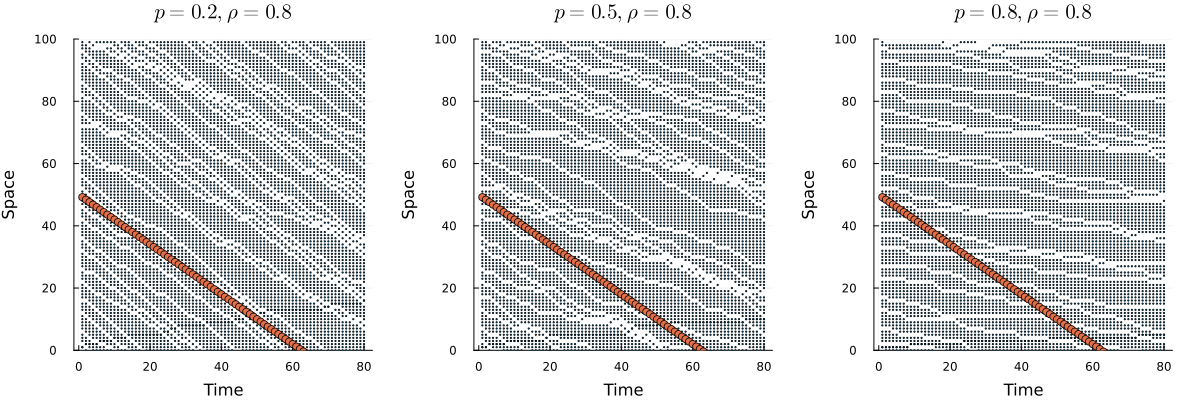

In [37]:
X = [Xp[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
T = [Tp[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
Pr = [P[i] for i in 1:length(P) for j in 1:length(Δ)]
D = [Δ[j] for i in 1:length(P) for j in 1:length(Δ)]
p = Vector{Any}(undef, 9)
for i in 1:9
    t = collect(1:80)
    p[i] = scatter(T[i], X[i], xlabel = "Time", ylabel = "Space", legend = false,
        title = L"$p = %$(Pr[i]), \rho = %$(D[i])$", ms = 0.8)
    plot!(t, -0.8.*t .+ 50, legend = false, ylim = (0,100), seriestype=:scatter)
end
plot(p[3],p[6],p[9], layout = (1,3), size = (1200,400), margin = 5*Plots.mm)

#savefig("NaSch")

In [38]:
savefig("NaSch_real")

"D:\\M.Sc. Courses\\3. SoSe 2022\\4. Data Analysis in Physics and Astronomy\\Exercises\\Agents\\NaSch\\NaSch_real.png"

In [7]:
len = 100
P = [0.2, 0.5, 0.8]
δ = [0.01:0.01:1.0;]

Jvals = Vector{Vector}()
Dvals = Vector{Vector}()
for p in P
    Jp = Vector{Float64}()
    Dp = Vector{Float64}()
    for d in δ
        r = Road(d, len)
        m = NaSch(r, 5, p)
        _, v, _ = simulate!(m, 500, scheme = 1)
        push!(Jp, J(ρ(m),v))
        push!(Dp, ρ(m))
    end
    push!(Jvals, Jp)
    push!(Dvals, Dp)
end

In [81]:
Js = [[J(d,p) for d in δ] for p in P]
labels = [L"$p = 0.2$" L"$p = 0.5$" L"$p = 0.8$"]
label_colors = Dict(L"$p = 0.2$" => :red, 
    L"$p = 0.5$" => :blue, L"$p = 0.8$" => :green)
s1 = scatter(Dvals, Jvals, xlabel = "Density", ylabel = "Current", ms = 1.7,
    label = labels, markercolor=[label_colors[label] for label in labels])

savefig("NaSch_FD")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/NaSch_FD.png"

This is the fundamental diagram for the NaSch. As expected, flow rate or current decreases with increase in slow-down probability $p$. The current steadily only decreases after $\rho \geq 0.25$ (depending on $p$) and this is likely an artefact of the chosen $v_{max}$ as well. 

In [95]:
len = 100
P = [0.0, 0.5, 0.8]
Δ = [0.2, 0.5, 0.8]

Xp = Vector{Vector}()
Vp = Vector{Vector}()
Tp = Vector{Vector}()
Dp = Vector{Vector}()
for p in P
    X = Vector{Vector{Int64}}()
    V = Vector{Vector{Int64}}()
    T = Vector{Vector{Int64}}()
    D = Vector{Float64}()
    for d in Δ
        r = Road(d, len)
        m = NaSch(r, 7, p)
        (x, v, t) = simulate!(m, 80, scheme = 1, VDR = true)
        push!(X, x)
        push!(V, v)
        push!(T, t)
        push!(D, ρ(m))
    end
    push!(Xp, X)
    push!(Vp, V)
    push!(Tp, T)
    push!(Dp, D)
end

In [96]:
X = [Xp[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
T = [Tp[pi][dj] for pi in 1:length(P) for dj in 1:length(Δ)]
Pr = [P[i] for i in 1:length(P) for j in 1:length(Δ)]
D = [Δ[j] for i in 1:length(P) for j in 1:length(Δ)]

p = [scatter(X[i], T[i], xlabel = "Space", ylabel = "Time", legend = false,
        title = L"$p = %$(Pr[i]), \rho = %$(D[i])$", ms = 0.8) for i in 1:9]
plot(p..., layout = (3,3), size = (1000,1000), margin = 5*Plots.mm)

savefig("VDR")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/VDR.png"

These are space-time diagrams for the VDR model with $v_{max} = 5$ with the first plot being for $q = 90\% \ (p = 10\%)$ and $\rho = 0.5$. Due to the VDR, we can see that the occurence of the jams are random, but more dominant in regions with almost vertical slope which corressponds to slower cars.

In [97]:
len = 100
P = [0.2, 0.5, 0.8]
δ = [0.01:0.01:1.0;]

Jvals = Vector{Vector}()
Dvals = Vector{Vector}()
for p in P
    Jp = Vector{Float64}()
    Dp = Vector{Float64}()
    for d in δ
        r = Road(d, len)
        m = NaSch(r, 7, p)
        _, v, _ = simulate!(m, 500, scheme = 1, VDR = true)
        push!(Jp, J(ρ(m),v))
        push!(Dp, ρ(m))
    end
    push!(Jvals, Jp)
    push!(Dvals, Dp)
end

In [98]:
Js = [[J(d,p) for d in δ] for p in P]
labels = [L"$p = 0.2$" L"$p = 0.5$" L"$p = 0.8$"]
label_colors = Dict(L"$p = 0.2$" => :red, 
    L"$p = 0.5$" => :blue, L"$p = 0.8$" => :green)
s1 = scatter(Dvals, Jvals, xlabel = "Density", ylabel = "Current", ms = 1.7,
    label = labels, markercolor=[label_colors[label] for label in labels])

savefig("VDR_FD")

"/afs/rrz.uni-koeln.de/usr/smail/05/ssriniv1/Downloads/VDR_FD.png"

Being essentially the same as the NaSch model but with a "bias" in the randomisation, the fundamental diagram doesn't have anything different to offer.